<a href="https://colab.research.google.com/github/SUBHADEEP1710/SMS-Spam-Detection/blob/master/SMS_Spam_Detection_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'

In [ ]:
! kaggle datasets download -d uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 20.8MB/s]


In [ ]:
! unzip /content/sms-spam-collection-dataset.zip

Archive:  /content/sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [ ]:
data = pd.read_csv("spam.csv", encoding="ISO-8859-1")

In [ ]:
data

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though
...,...,...
5567,spam,2nd time tri 2 contact u u å750 pound prize 2 ...
5568,ham,ì_ b go esplanad fr home
5569,ham,piti mood soani suggest
5570,ham,guy bitch act like id interest buy someth els ...


In [ ]:
# Keep only the necessary columns and renaming them for clarity

data = data[['v1', 'v2']]

data.columns = ['label', 'text']

data = data[['label', 'text']]

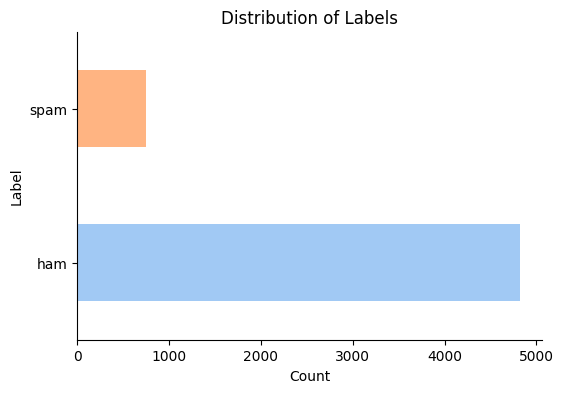

In [ ]:
# Visualize the distribution of labels
plt.figure(figsize=(6, 4))
data.groupby('label').size().plot(kind='barh', color=sns.color_palette('pastel'))
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Distribution of Labels')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [ ]:
# Data Pre-processing
data['text'] = data['text'].str.lower()

data['text'] = data['text'].apply(lambda x: x.strip())

data['text'] = data['text'].str.split()

data['text'] = data['text'].apply(lambda x: [re.sub(r'\W', '', word) for word in x])

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stop_words])

stemmer = PorterStemmer()
data['text'] = data['text'].apply(lambda x: [stemmer.stem(word) for word in x])

data['text'] = data['text'].apply(lambda x: " ".join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=35)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'clf__alpha': (1e-2, 1e-3)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5)
grid_search.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)



Best parameters set found on development set:
{'clf__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}


Accuracy: 0.9847533632286996
Classification Report:
               precision    recall  f1-score   support

         ham       0.99      1.00      0.99       968
        spam       0.98      0.90      0.94       147

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix:
 [[965   3]
 [ 14 133]]


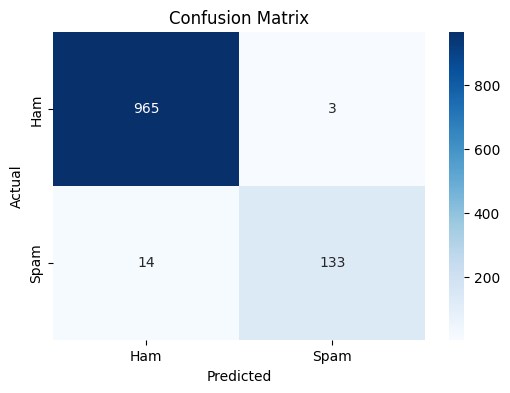

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

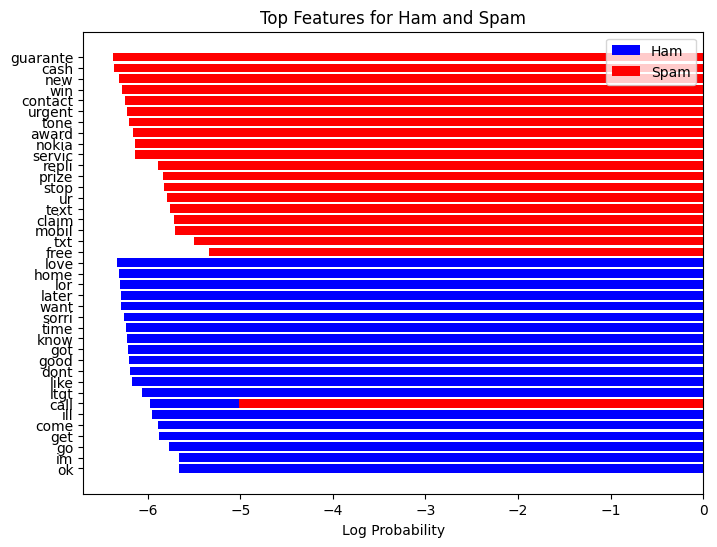

In [ ]:
def plot_top_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names_out()
    log_prob = clf.feature_log_prob_


    top_features = []
    for i in range(log_prob.shape[0]):
        top_n = np.argsort(log_prob[i])[-n:]
        for j in top_n:
            top_features.append((feature_names[j], log_prob[i][j], i))


    top_features.sort(key=lambda x: x[1], reverse=True)

    # Split features into labels
    ham_features = [f for f in top_features if f[2] == 0]
    spam_features = [f for f in top_features if f[2] == 1]


    plt.figure(figsize=(8, 6))
    plt.barh([f[0] for f in ham_features[:n]], [f[1] for f in ham_features[:n]], color='blue', label='Ham')
    plt.barh([f[0] for f in spam_features[:n]], [f[1] for f in spam_features[:n]], color='red', label='Spam')
    plt.xlabel('Log Probability')
    plt.title('Top Features for Ham and Spam')
    plt.legend()
    plt.show()


best_vectorizer = grid_search.best_estimator_.named_steps['tfidf']
best_clf = grid_search.best_estimator_.named_steps['clf']
plot_top_features(best_vectorizer, best_clf)